In [1]:
import os
from zipfile import ZipFile
from os import listdir

import numpy as np
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import pathlib
import datetime

import kagglehub
import shutil

C:\Users\Chiara\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Download dataset and divide into folders

In [2]:
# to remove the directory (in case)

dir_to_remove = "cats_and_dogs_filtered"

if os.path.exists(dir_to_remove):
    shutil.rmtree(dir_to_remove)
    print("Directory eliminata")
else:
    print("La directory non esiste")

Directory eliminata


In [3]:
# Dowload dataset

path = kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")

In [4]:
path

'C:\\Users\\Chiara\\.cache\\kagglehub\\datasets\\tanlikesmath\\the-oxfordiiit-pet-dataset\\versions\\1'

In [5]:
os.listdir(path)

['images']

In [6]:
images_path = os.path.join(path, "images")
os.listdir(images_path)[:10] 

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_100.mat',
 'Abyssinian_101.jpg',
 'Abyssinian_101.mat',
 'Abyssinian_102.jpg',
 'Abyssinian_102.mat',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg']

Since there are no annotations, I need to find it by myself. I can use the name of each animal to understand if it is a cat or a dog.

In [7]:
images_path = os.path.join(path, "images")

species = set()

for fname in os.listdir(images_path):
    if fname.endswith(".jpg"):
        name = fname.rsplit("_", 1)[0] 
        species.add(name)

print(f"# of Species: {len(species)}")
sorted(species)

# of Species: 37


['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [8]:
images_path = os.path.join(path, "images")

all_images = [f for f in os.listdir(images_path) if f.endswith(".jpg")]
print("Total images:", len(all_images))

Total images: 7390


In [9]:
random.seed(42) 
random.shuffle(all_images)

split_ratio = 0.95
split = int(split_ratio * len(all_images))

train_images = all_images[:split]
validation_images = all_images[split:]

In [10]:
# structure of folders

base_dir = "cats_and_dogs_filtered"

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

train_cats_dir = os.path.join(train_dir, "cats")
validation_cats_dir = os.path.join(validation_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

for d in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]: 
    os.makedirs(d, exist_ok=True)

In [11]:
def is_cat(filename):
    return filename[0].isupper()  # I notice that cats have upper letters

In [12]:
# copy images in their corresponding folders

def copy_images(file_list, cats_dir, dogs_dir):
    for fname in file_list:
        src = os.path.join(images_path, fname)

        if is_cat(fname):
            dst = os.path.join(cats_dir, fname)
        else:
            dst = os.path.join(dogs_dir, fname)

        shutil.copy(src, dst)

In [13]:
copy_images(train_images, train_cats_dir, train_dogs_dir)
copy_images(validation_images, validation_cats_dir, validation_dogs_dir)

In [14]:
# check

print('total training cat images :', len(listdir(train_cats_dir)))
print('total training dog images :', len(listdir(train_dogs_dir)))

print('total validation cat images :', len(listdir(validation_cats_dir)))
print('total validation dog images :', len(listdir(validation_dogs_dir)))

print("Sum: ", (len(listdir(train_cats_dir))+len(listdir(train_dogs_dir))+len(listdir(validation_cats_dir))+len(listdir(validation_dogs_dir))))

total training cat images : 2291
total training dog images : 4729
total validation cat images : 109
total validation dog images : 261
Sum:  7390


In [16]:
# print some training images

train_cat_fnames = listdir(train_cats_dir)
train_dog_fnames = listdir(train_dogs_dir)

random.shuffle(train_cat_fnames)
random.shuffle(train_dog_fnames)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['Bombay_200.jpg', 'Bengal_162.jpg', 'Maine_Coon_23.jpg', 'Ragdoll_254.jpg', 'Ragdoll_119.jpg', 'Persian_39.jpg', 'Birman_74.jpg', 'Ragdoll_9.jpg', 'Ragdoll_219.jpg', 'British_Shorthair_139.jpg']
['pomeranian_94.jpg', 'boxer_3.jpg', 'english_setter_139.jpg', 'boxer_198.jpg', 'scottish_terrier_41.jpg', 'leonberger_38.jpg', 'scottish_terrier_185.jpg', 'keeshond_82.jpg', 'american_bulldog_90.jpg', 'pomeranian_20.jpg']


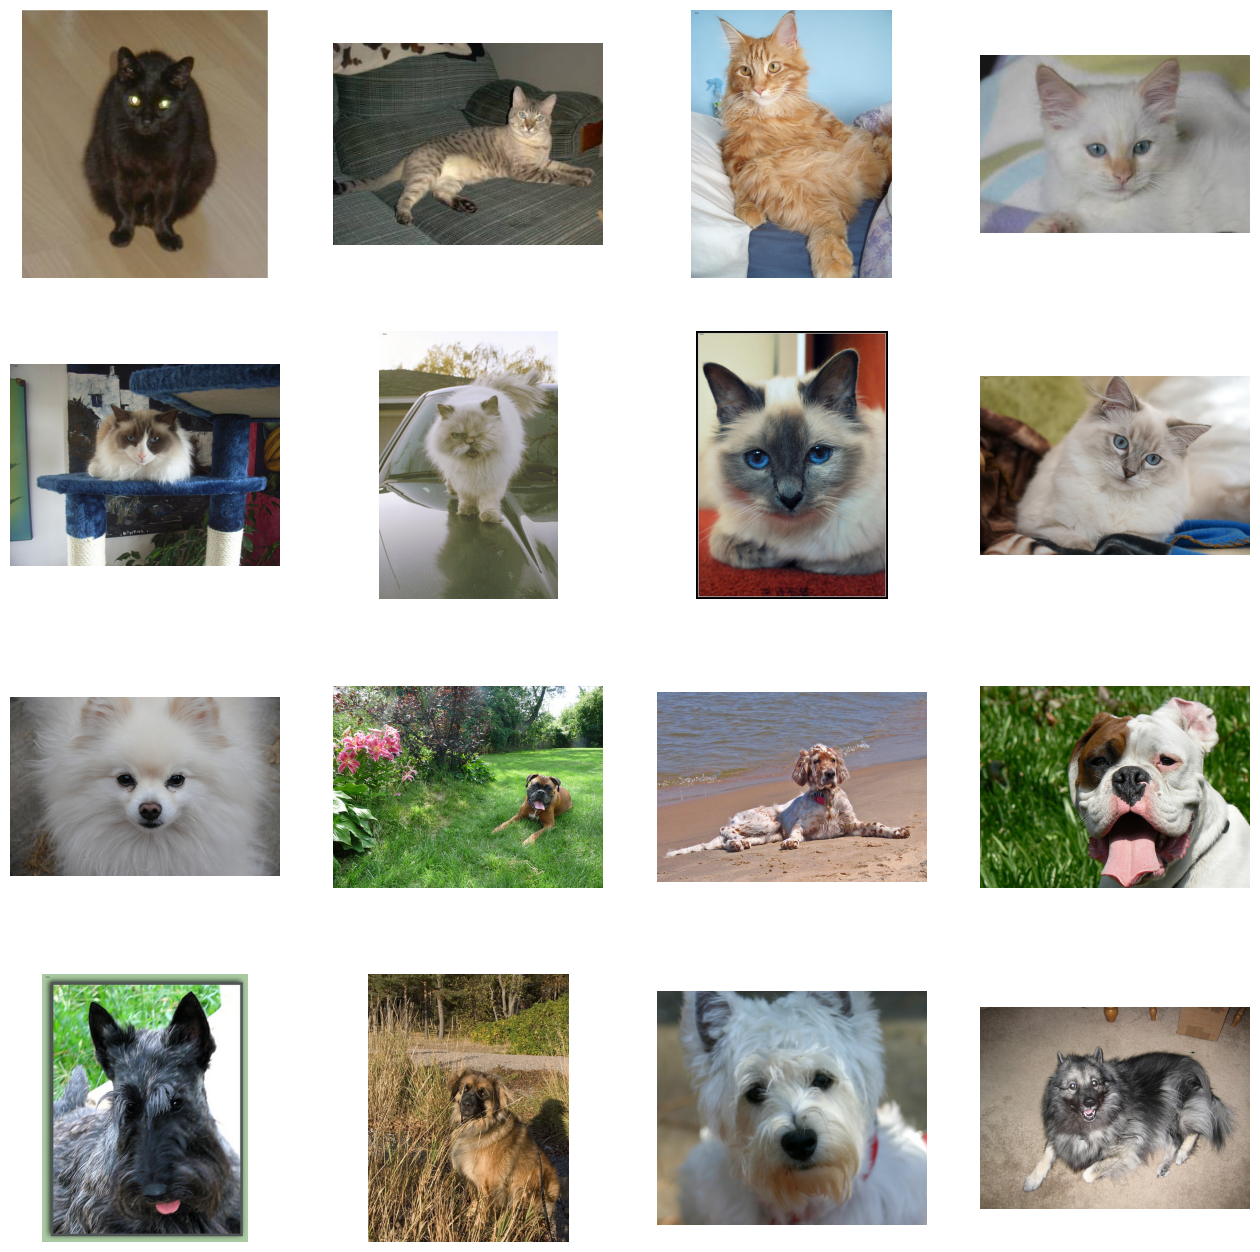

In [20]:
ncols = 4
nrows = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis("Off")
    img = mpimg.imread(img_path)
    plt.imshow(img)

# Model

In [22]:
model = Sequential([
    # The input shape is the size of the image 150x150x3
    Conv2D(16, (3,3), activation="relu", input_shape=(150,150,3)),  # 16 filters with 3 channels
    MaxPooling2D(2,2),

    # Flatten the results for the DNN
    Flatten(),

    # Hidden layer with 64 neurons
    Dense(64, activation="relu"),

    # 1 output neuron in [0,1] where 0 is for cats and 1 for dogs
    Dense(1, activation="sigmoid")
])

C:\Users\Chiara\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,608,001 (21.39 MB)

 Trainable params: 5,608,001 (21.39 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
# rescaling images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, class_mode="binary", target_size=(150,150))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size=16, class_mode="binary", target_size=(150,150))

Found 7020 images belonging to 2 classes.
Found 370 images belonging to 2 classes.


In [26]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=15, batch_size=16, verbose=2)

Epoch 1/15
439/439 - 50s - 113ms/step - accuracy: 0.6818 - loss: 0.7429 - val_accuracy: 0.7595 - val_loss: 0.5459
Epoch 2/15
439/439 - 20s - 45ms/step - accuracy: 0.7788 - loss: 0.4685 - val_accuracy: 0.7459 - val_loss: 0.5113
Epoch 3/15
439/439 - 19s - 44ms/step - accuracy: 0.8573 - loss: 0.3439 - val_accuracy: 0.7514 - val_loss: 0.5193
Epoch 4/15
439/439 - 20s - 45ms/step - accuracy: 0.9239 - loss: 0.2133 - val_accuracy: 0.7541 - val_loss: 0.6129
Epoch 5/15
439/439 - 19s - 44ms/step - accuracy: 0.9628 - loss: 0.1219 - val_accuracy: 0.7270 - val_loss: 0.7504
Epoch 6/15
439/439 - 19s - 44ms/step - accuracy: 0.9842 - loss: 0.0653 - val_accuracy: 0.7000 - val_loss: 0.9425
Epoch 7/15
439/439 - 19s - 44ms/step - accuracy: 0.9939 - loss: 0.0359 - val_accuracy: 0.7351 - val_loss: 1.0152
Epoch 8/15
439/439 - 20s - 45ms/step - accuracy: 0.9929 - loss: 0.0365 - val_accuracy: 0.7189 - val_loss: 1.1957
Epoch 9/15
439/439 - 20s - 45ms/step - accuracy: 0.9913 - loss: 0.0372 - val_accuracy: 0.7351 -

In [27]:
model.evaluate(validation_generator)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7405 - loss: 1.9714


[1.9714041948318481, 0.7405405640602112]

# Small test

In [44]:
from PIL import Image

In [45]:
class_names = list(train_generator.class_indices)
class_names

['cats', 'dogs']

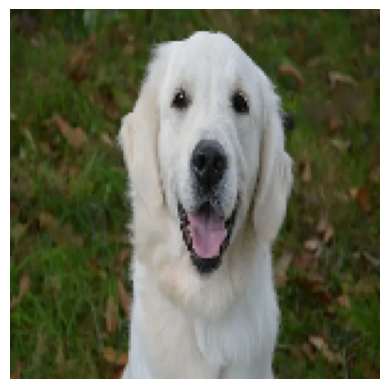

In [51]:
img_path = r"C:\Users\Chiara\Pictures\test_cane_2.webp"

img = load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.axis("off")
plt.show()

In [52]:
img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [53]:
pred = model.predict(img_array)[0][0]

class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

predicted_class = inv_class_indices[int(pred > 0.5)]

print(f"Prediction: {predicted_class} ({pred:.3f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: dogs (1.000)


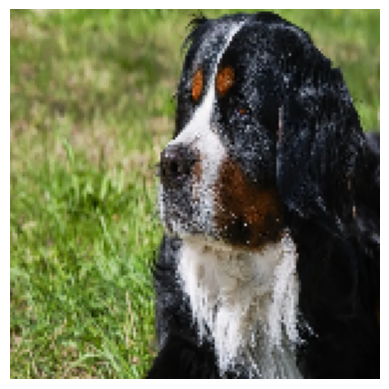

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: dogs (1.000)


In [55]:
img_path = r"C:\Users\Chiara\Pictures\test_cane_1.webp"

img = load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.axis("off")
plt.show()

img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]

class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

predicted_class = inv_class_indices[int(pred > 0.5)]

print(f"Prediction: {predicted_class} ({pred:.3f})")

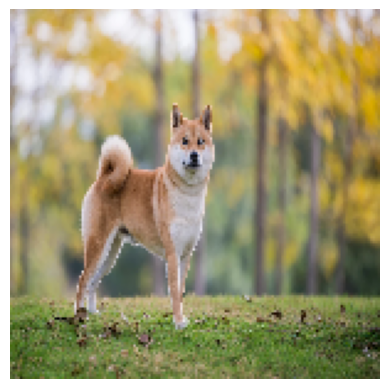

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: dogs (1.000)


In [57]:
img_path = r"C:\Users\Chiara\Pictures\test_cane_3.webp"

img = load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.axis("off")
plt.show()

img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]

class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

predicted_class = inv_class_indices[int(pred > 0.5)]

print(f"Prediction: {predicted_class} ({pred:.3f})")

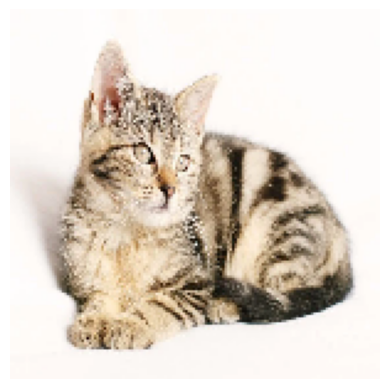

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: cats (0.009)


In [62]:
img_path = r"C:\Users\Chiara\Pictures\test_cat_1.webp"

img = load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.axis("off")
plt.show()

img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]

class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

predicted_class = inv_class_indices[int(pred > 0.5)]

print(f"Prediction: {predicted_class} ({pred:.3f})")

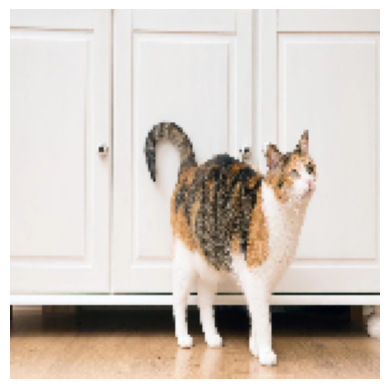

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: dogs (1.000)


In [63]:
img_path = r"C:\Users\Chiara\Pictures\test_cat_2.webp"

img = load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.axis("off")
plt.show()

img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]

class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

predicted_class = inv_class_indices[int(pred > 0.5)]

print(f"Prediction: {predicted_class} ({pred:.3f})")

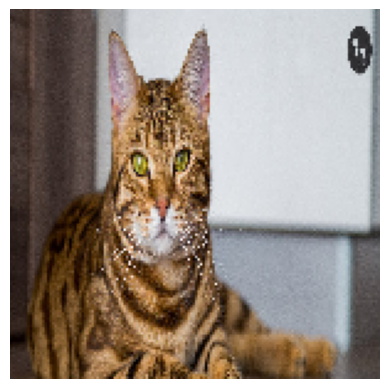

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: dogs (0.997)


In [64]:
img_path = r"C:\Users\Chiara\Pictures\test_cat_3.jpg"

img = load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.axis("off")
plt.show()

img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]

class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

predicted_class = inv_class_indices[int(pred > 0.5)]

print(f"Prediction: {predicted_class} ({pred:.3f})")

While the model seems good to classify the dogs, it is not true for cats. Maybe this is due to an unbalance in the number of pictures of cats and dogs in the training set

In [65]:
num_cats = len(os.listdir(train_cats_dir))
num_dogs = len(os.listdir(train_dogs_dir))

print("Training set:")
print("Cats:", num_cats)
print("Dogs:", num_dogs)

Training set:
Cats: 2291
Dogs: 4729
